In [6]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch

from datasets import build_dataset
from model import build_model
from engine import get_correct_number

In [9]:
root = 'DLP_MODEL'
model_names = ['resnet50', 'VIT_small', 'VIT_base']
model_pathes = ['resnet50', 'Vit_small_dropout_0.4', 'Vit_base_dropout_0.4']

best_acc_list = list()
best_mae_list = list()
for model_path in model_pathes:
    f = open(f'{root}/{model_path}/log.txt', 'r')
    lines = f.read().split('\n')[:-1]
    
    best_acc = max([float(line.split(' ')[-4]) for line in lines])
    best_mae = min([float(line.split(' ')[-1]) for line in lines])
    
    best_acc_list.append(best_acc)
    best_mae_list.append(best_mae)
    
df = pd.DataFrame({
    'best_acc': best_acc_list,
    'best_mae': best_mae_list
})
df = df.T
df.columns = model_names
display(df)

,resnet50,VIT_small,VIT_base
best_acc,96.39,98.22,98.39
best_mae,3.49,3.01,2.95


In [3]:
best_model_name = 'Vit_base_dropout_0.4'
saved_model = torch.load(f'{root}/{best_model_name}/best_gender.pth')
args = saved_model['args']
args.data_path = 'AFAD-Full'
args.batch_size = 8
device = args.device

model = build_model(model_name=args.model, model_type=args.model_type)
model.load_state_dict(saved_model['model'])
model = model.to(device)
dataset_val = build_dataset(args, is_train=False)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=int(1.5 * args.batch_size),
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=False
)

Building datasets from AFAD-Full


In [6]:
age_true = list()
age_pred = list()
gender_true = list()
gender_pred = list()

criterion_age = torch.nn.L1Loss()
criterion_gender = torch.nn.BCELoss()

progress = tqdm(total=len(data_loader_val))

model.eval()
for inputs, target_age, target_gender in data_loader_val:
    inputs = inputs.to(device)
    target_gender = target_gender.reshape(-1,1).type(torch.FloatTensor).to(device)
    target_age = target_age.reshape(-1,1).type(torch.FloatTensor).to(device)

    age, gender = model(inputs)
    
    age_true.append(target_age.cpu().detach().numpy())
    age_pred.append(age.cpu().detach().numpy())
    gender_true.append(target_gender.cpu().detach().numpy())
    gender_pred.append(gender.cpu().detach().numpy())
    
    progress.update(1)
    
age_true = np.concatenate(age_true)
age_pred = np.concatenate(age_pred)
gender_true = np.concatenate(gender_true)
gender_pred = np.concatenate(gender_pred)
gender_pred = [(1 if y>0.5 else 0) for y in gender_pred]

  0%|          | 0/2741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        male       0.99      0.98      0.99     20220
      female       0.98      0.98      0.98     12664

    accuracy                           0.98     32884
   macro avg       0.98      0.98      0.98     32884
weighted avg       0.98      0.98      0.98     32884



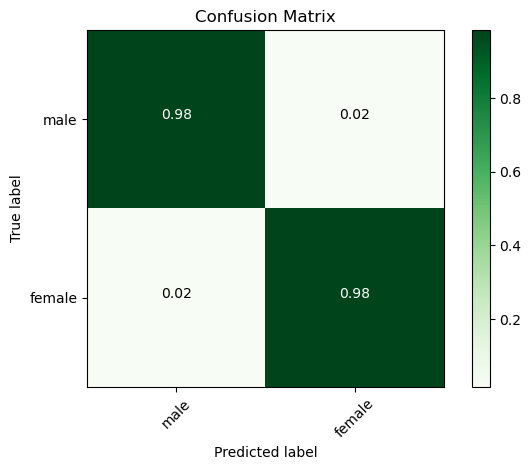

In [52]:
gender_label = ['male', 'female']
report = classification_report(
                    gender_true, 
                    gender_pred, 
                    target_names=gender_label)
print(report)

cm = confusion_matrix(gender_true, gender_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cmap=plt.cm.Greens
title='Confusion Matrix'
classes = gender_label

plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = '.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

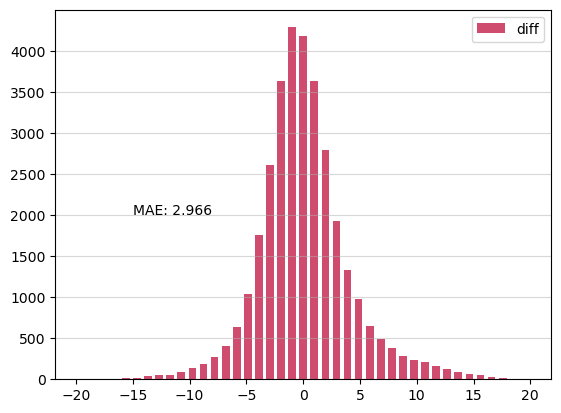

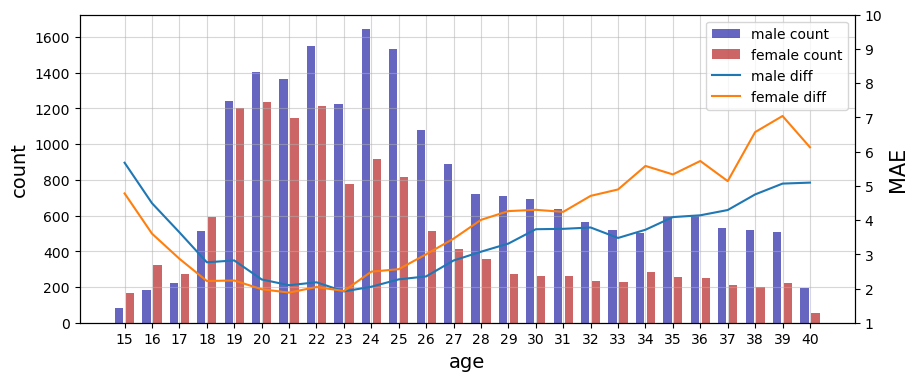

In [171]:
age_diff = age_true - np.round(age_pred)

plt.figure()
plt.grid(axis='y', alpha=0.5)
plt.hist(age_diff,
         bins=41,
         alpha=0.7,
         color='#BB0030',
         rwidth=0.7,
         label='diff'
        )
plt.text(-15, 2000, f'MAE: {np.abs(age_diff).mean():.3f}')
plt.legend()

male_count = [0] * 41
female_count = [0] * 41
male_diff = [0] * 41
female_diff = [0] * 41

for age in range(15, 41):
    age_indices = np.where(age_true == age)[0]
    gender_indices = np.where(gender_true == 0)[0]
    indices = np.intersect1d(age_indices, gender_indices)

    male_count[age] = len(indices)
    male_diff[age] = np.abs(age_diff[indices]).mean()

for age in range(15, 41):
    age_indices = np.where(age_true == age)[0]
    gender_indices = np.where(gender_true == 1)[0]
    indices = np.intersect1d(age_indices, gender_indices)

    female_count[age] = len(indices)
    female_diff[age] = np.abs(age_diff[indices]).mean()
    
index = np.array([i for i in range(15, 41)])

plt.figure(figsize=(10, 4))
plt.grid(alpha=0.5)
l1 = plt.bar(x=index-0.2, 
        height=male_count[15:41],
        width=0.3,
        color='#000099',
        alpha=0.6,
        label='male count')
l2 = plt.bar(x=index+0.2, 
        height=female_count[15:41],
        width=0.3,
        color='#AA0000',
        alpha=0.6,
        label='female count')
plt.xticks(index)
plt.xlabel('age', fontsize=14)
plt.ylabel('count', fontsize=14)
# plt.legend()

plt.twinx()
l3 = plt.plot(index, male_diff[15:41], label = 'male diff')
l4 = plt.plot(index, female_diff[15:41], label = 'female diff')
plt.ylim(1, 10)
plt.ylabel('MAE', fontsize=15)
plt.legend(handles = [l1]+[l2]+l3+l4, loc='best')

plt.show()